## Text summarization project using various unsupervised learning approaches

Name: Sarah Darlyna Bt Mohd Radzi

Student ID: 0134768

### 1. Introduction

Text summarization involves shortening the length of a given text/document while still retaining its context and key information. There are various applications of automatic text summarization, including condensing customer reviews, summarizing news articles, and creating summary reports from business meeting notes. 

Text summarization is crucial in today's age in which works are rapidly done and time is an investment, the need of quick summary of an important document and text is important in order to quickly execute a task or research while handling multiple documents. A good text summarization system saves the user’s effort and time to get the desired data from the text without needing to read the whole text 

There are two methods in develops the model for text summarization: extractive and abstractive. In this notebook, this project will use extractive methods. The Extractive based summarization method selects informative sentences from the document as they exactly appear in source based on specific criteria to form summary. The main challenge before extractive summarization is to decide which sentences from the input document is significant and likely to be included in the summary. For this task, sentence scoring is employed based on features of sentences. It first, assigns a score to each sentence based on feature then rank sentences according to their score. Sentences with the highest score are likely to be included in final summary.

There are three different approaches/models which inlcudes K-Means Clusterer, TF-IDF model and PageRank approach use for this project. Furthermore, the evaluation of the performance of each models will be by using BLEU and ROGUE scores.

#### 1.1 Hypotheses 

H0: Generated summary is not better than original summary

H1: Generated summary is better than original summary

In [1]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2') #Huggingface pre-trained model, all-mini

2023-11-29 08:49:38.190859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import re
import seaborn as sb
from scipy.spatial import distance
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import pandas as pd
from nltk.cluster import KMeansClusterer
from scipy.spatial import distance_matrix
import numpy as np
import os
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from heapq import nlargest
from string import punctuation
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from evaluate import load
from pathlib import Path
# Load the ROUGE metric
import evaluate
punctuation = punctuation + '\n' + '—' + '“' + ',' + '”' + '‘' + '-' + '’'

In [3]:
def extract(filepath):
    pattern = r'(\w+)/(\d+)\.txt$'
    category, file_id = re.search(pattern, str(filepath)).groups()
    with open(filepath, 'r', encoding='unicode_escape') as f:
        text = f.read()
        return category, file_id, text



In [4]:
dataset_path = Path('/Users/sarahdarlyna/Downloads/BBC News Summary')

In [5]:
articles_data = list(map(extract, dataset_path.glob('News Articles/*/*.txt')))
summaries_data = list(map(extract, dataset_path.glob('Summaries/*/*.txt')))

articles_df = pd.DataFrame(articles_data, columns=('Category', 'ID', 'Article'))
summaries_df = pd.DataFrame(summaries_data, columns=('Category', 'ID', 'Summary'))

df = articles_df.merge(summaries_df, how='inner', on=('Category', 'ID'))

### 2. Dataset selection 

This section is used to convert a collection of txt files into a dataframe by using the library from pathlib.
This dataset is collected from Kaggle, an online data sources that is widely used by data scientist and researchers worldwide. The dataset that was used for this research involves the BBC articles as well as its own generated summary. This dataset includes features that are useful for this project's research question as it includes its own generated summary to compare with this project's model generated summarization and to evaluate the accuracy score by using BLEU and ROGUE. Hence, to see whether there's an improvement towards the summary generated compare to original summary.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   ID        2225 non-null   object
 2   Article   2225 non-null   object
 3   Summary   2225 non-null   object
dtypes: object(4)
memory usage: 86.9+ KB


The dataset contains 4 features: 'Category', 'ID', 'Article' and 'Summary'.
Furthermore, the number of rows are 2225.

In [7]:
df.head()

,Category,ID,Article,Summary
0,entertainment,289,Musicians to tackle US red tape\n\nMusicians' ...,Nigel McCune from the Musicians' Union said Br...
1,entertainment,262,"U2's desire to be number one\n\nU2, who have w...",But they still want more.They have to want to ...
2,entertainment,276,Rocker Doherty in on-stage fight\n\nRock singe...,"Babyshambles, which he formed after his acrimo..."
3,entertainment,060,Snicket tops US box office chart\n\nThe film a...,A Series of Unfortunate Events also stars Scot...
4,entertainment,074,Ocean's Twelve raids box office\n\nOcean's Twe...,"Ocean's Twelve, the crime caper sequel starrin..."


From the dataset above, article and summary will chosen to be used as train data as well as test data.

#### 2.1 Train text and train summary

In [8]:
train_text = df['Article'][0]
train_text

'Musicians to tackle US red tape\n\nMusicians\' groups are to tackle US visa regulations which are blamed for hindering British acts\' chances of succeeding across the Atlantic.\n\nA singer hoping to perform in the US can expect to pay $1,300 (Â£680) simply for obtaining a visa. Groups including the Musicians\' Union are calling for an end to the "raw deal" faced by British performers. US acts are not faced with comparable expense and bureaucracy when visiting the UK for promotional purposes.\n\nNigel McCune from the Musicians\' Union said British musicians are "disadvantaged" compared to their US counterparts. A sponsor has to make a petition on their behalf, which is a form amounting to nearly 30 pages, while musicians face tougher regulations than athletes and journalists. "If you make a mistake on your form, you risk a five-year ban and thus the ability to further your career," says Mr McCune.\n\n"The US is the world\'s biggest music market, which means something has to be done abo

In [9]:
train_summary = df['Summary'][0]
train_summary

'Nigel McCune from the Musicians\' Union said British musicians are "disadvantaged" compared to their US counterparts.A US Embassy spokesman said: "We are aware that entertainers require visas for time-specific visas and are doing everything we can to process those applications speedily."The Musicians\' Union stance is being endorsed by the Music Managers\' Forum (MMF), who say British artists face "an uphill struggle" to succeed in the US, thanks to the tough visa requirements, which are also seen as impractical.Musicians\' groups are to tackle US visa regulations which are blamed for hindering British acts\' chances of succeeding across the Atlantic."The US is the world\'s biggest music market, which means something has to be done about the creaky bureaucracy," says Mr McCune."The current situation is preventing British acts from maintaining momentum and developing in the US," he added.A singer hoping to perform in the US can expect to pay $1,300 (Â£680) simply for obtaining a visa.'

#### 2.2. Explarotary Data Analysis

The EDA conducted is a brief visualization of the number of articles based on categories. From the countplot below, it concludes that the most common category of BBC articles are business and sport while entertainment the least content.

Text(0.5, 1.0, 'Category')

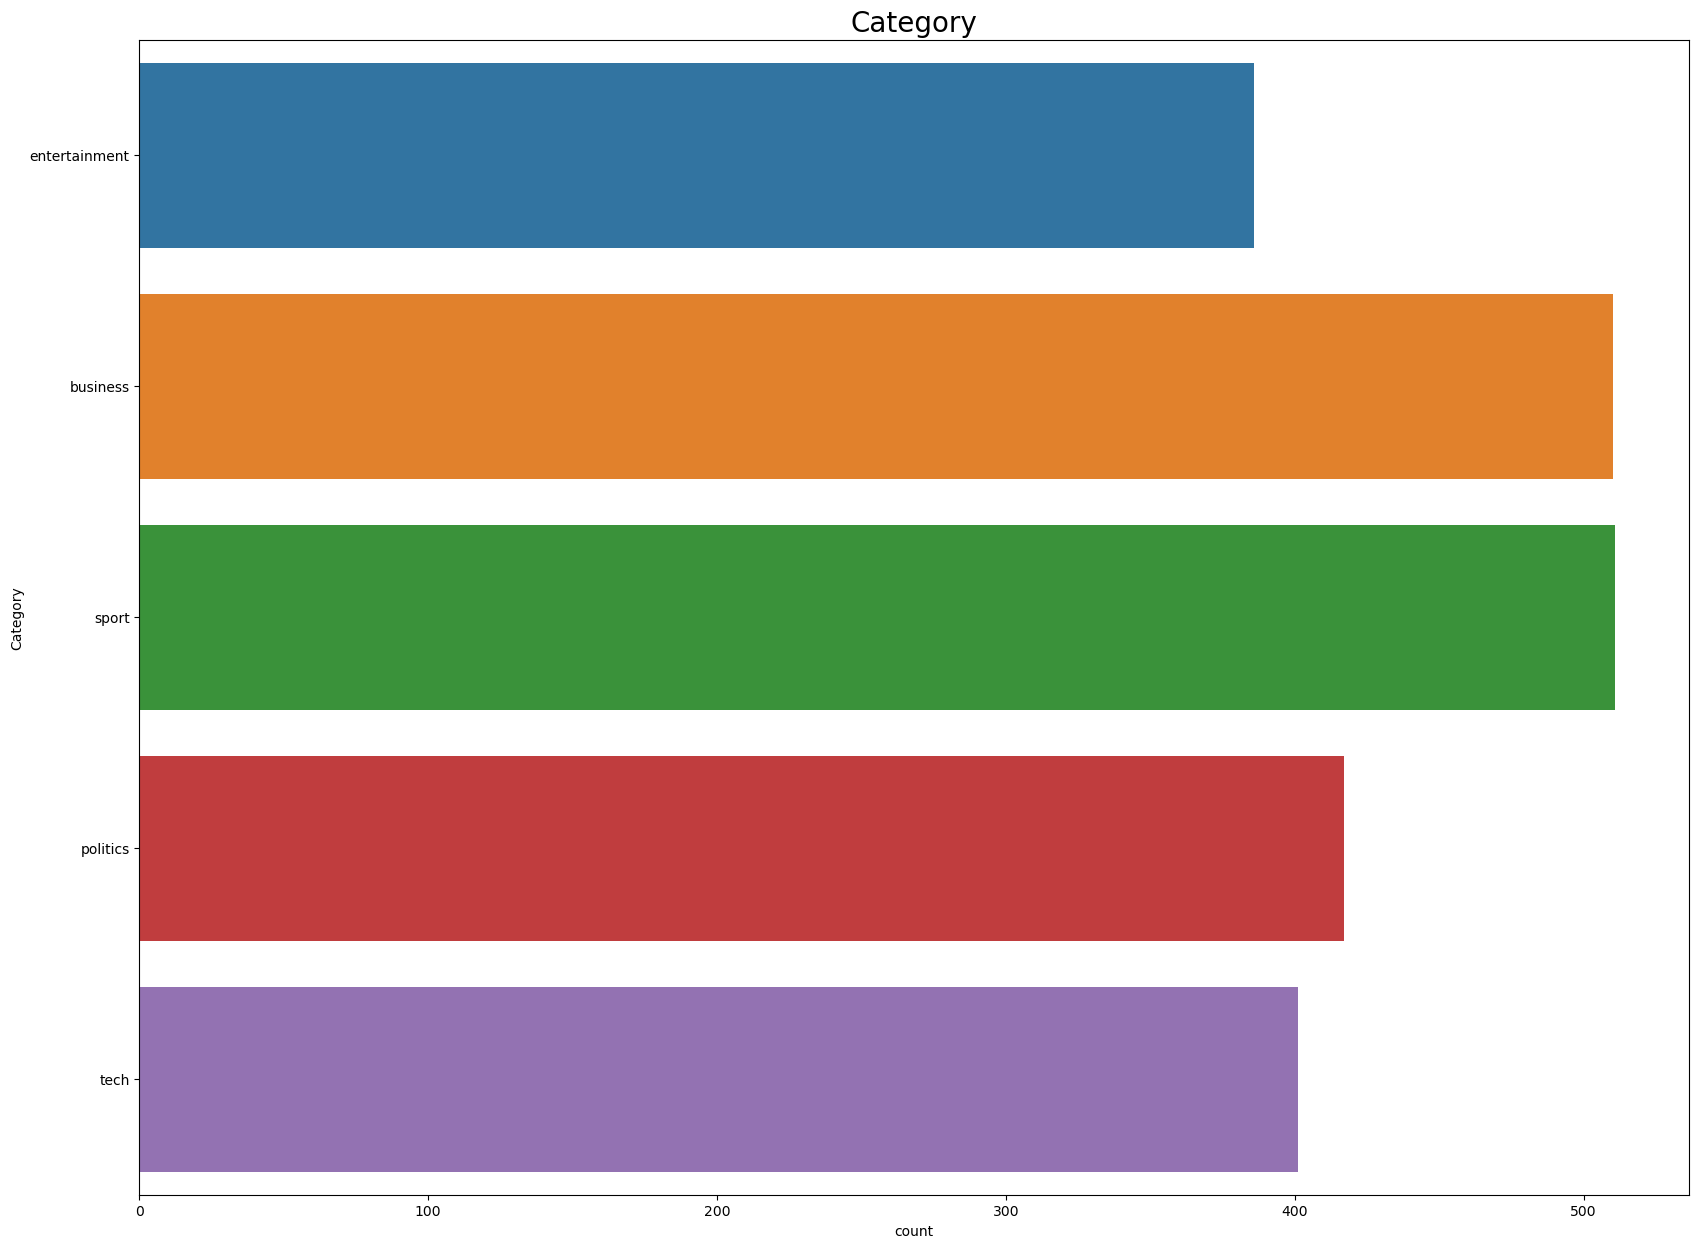

In [10]:
plt.figure(figsize = (20,15)) ##height 20, width 15
sb.countplot(y = df.Category)
plt.title("Category", fontsize = 20)

### 3. Brief Pre-processing

The pre-processing includes in this model is removing stopwords, expanding contraction word, tokenizing the text. Text summarization does not require an intensive pre-processing as it needs to retain the content of the text used to be train and generate a good summary. 


#### 3.1Tokenization
In this step the document is divided into paragraphs, then the paragraphs into sentences, and finally the sentences into words.

#### 3.2 Removing stopwords
Removing stop words reduces the text to more useful words. And the non-removal affects the efficiency of the process of weighting.

#### 3.3 Expand contraction list
Contractions are words or combinations of words that are shortened by dropping letters and replacing them by an apostrophe. Removing contractions contributes to text standardization and helps in text summarization when it comes to rank important sentences in order to understand the context of the text.

In [11]:
contraction_list = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [12]:
stop_words = set(stopwords.words('english'))

In [13]:
def text_cleaner(text):
    newString = ' '.join([contraction_list[t] if t in contraction_list else t for t in text.split(" ")]) # the dictionary that we will use for expanding the contractions
    
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words = []
    for i in tokens:
        if len(i) >= 3:  # removing short word
            long_words.append(i)
    return (" ".join(long_words)).strip()

This is the fuction for pre-processing texts. In this function includes removing stopwords and expanding the contraction list.

In [14]:
def tokenize_text(txt):
    
    #tokenize text
    sentences = nltk.sent_tokenize(txt)
    
    #to dataframe
    data = pd.DataFrame()
    data = pd.DataFrame(sentences)
    data.columns=['sentence']
    
    return data

def get_sentence_embeddings(sentence):
    embedding = model.encode([sentence])
    return embedding[0]


The functions above includes tokenizing the text and converting it into a dataframe for easier inspections. The second function is converting the tokenized text to its embedded vectors by using pre-trained model from SentenceTransformer.

In [15]:
tt = text_cleaner(train_text)
sentences=nltk.sent_tokenize(tt)

In [16]:
sentences

["Musicians tackle red tape Musicians' groups tackle visa regulations blamed hindering British acts' chances succeeding across Atlantic.",
 'singer hoping perform expect pay $1,300 (Â£680) simply obtaining visa.',
 'Groups including Musicians\' Union calling end "raw deal" faced British performers.',
 'acts faced comparable expense bureaucracy visiting promotional purposes.',
 'Nigel McCune Musicians\' Union said British musicians "disadvantaged" compared counterparts.',
 'sponsor make petition behalf, form amounting nearly pages, musicians face tougher regulations athletes journalists.',
 '"If make mistake form, risk five-year ban thus ability career," says McCune.',
 '"The world\'s biggest music market, means something done creaky bureaucracy," says McCune.',
 '"The current situation preventing British acts maintaining momentum developing US," added.',
 'The Musicians\' Union stance endorsed Music Managers\' Forum (MMF), say British artists face "an uphill struggle" succeed US, thank

Data will be tokenized into tokens based on the first punctuation before it will be convert into a dataframe as shows below.

### 4. Feature engineering 1: Sentence embeddings using pre-trained model from SentenceTransformer

Once the tokenized text is converted into a dataframe, each sentences on each tokens will be embedded to vectors for feature representation using a pre-trained model from SentenceTransformer.

Word embeddings represent words as dense vectors in a continuous vector space. It captures semantic relationships between words.

In [17]:
data = tokenize_text(tt)
data

,sentence
0,Musicians tackle red tape Musicians' groups ta...
1,"singer hoping perform expect pay $1,300 (Â£680..."
2,Groups including Musicians' Union calling end ...
3,acts faced comparable expense bureaucracy visi...
4,Nigel McCune Musicians' Union said British mus...
5,"sponsor make petition behalf, form amounting n..."
6,"""If make mistake form, risk five-year ban thus..."
7,"""The world's biggest music market, means somet..."
8,"""The current situation preventing British acts..."
9,The Musicians' Union stance endorsed Music Man...


In [18]:
data['embeddings'] = data['sentence'].apply(get_sentence_embeddings)

In [19]:
data

,sentence,embeddings
0,Musicians tackle red tape Musicians' groups ta...,"[0.047034286, -0.05700698, 0.03200802, -0.0207..."
1,"singer hoping perform expect pay $1,300 (Â£680...","[0.028535979, -0.0113964835, 0.027407581, -0.0..."
2,Groups including Musicians' Union calling end ...,"[-0.0038289719, -0.054160986, 0.00022078159, -..."
3,acts faced comparable expense bureaucracy visi...,"[0.0132861715, 0.021861676, -0.012200599, -0.0..."
4,Nigel McCune Musicians' Union said British mus...,"[0.11587219, -0.0411896, 0.014607726, -0.05767..."
5,"sponsor make petition behalf, form amounting n...","[0.027503742, 0.0531638, 0.029745325, -0.09349..."
6,"""If make mistake form, risk five-year ban thus...","[-0.074412145, 0.037071213, 0.058321945, -0.03..."
7,"""The world's biggest music market, means somet...","[0.06626549, -0.037928533, 0.033051696, -0.049..."
8,"""The current situation preventing British acts...","[0.012769175, -0.043569244, 0.03420545, -0.051..."
9,The Musicians' Union stance endorsed Music Man...,"[0.05617586, -0.103920616, -0.022874556, -0.04..."


Each tokens of sentences will have its embeddings (word representation) using the pre-trained model from SentenceTransformer called All-Mini which each words in each tokens will have its vectors. These embeddings will be used for the K-Means Clustering model to find its clusters, centroids and the distance between centroids before ranking it for summarization.

### 5.1 Apply K-means clustering (Model 1)

K-Means Clusterer is a clustering algorithm commonly used for grouping similar data points into clusters. In the context of text summarization, K-Means can be applied to group sentences or documents into clusters based on their content similarity. The idea is to identify representative sentences from each cluster to form a concise summary.

By using cluster of 10, the data from pre-processing will be converted to a list before being fitted into the KMeansClusterer model.

Furthermore, clusters will be assigned afterwards based on their embeddings and two new columns 'cluster' and 'centroid' will be created as a part of the data dataframe.

In [20]:
NUM_CLUSTERS = 10

In [21]:
from sklearn.metrics import silhouette_score
NUM_CLUSTERS=10

data_kmean = data

X = np.array(data_kmean['embeddings'].tolist())

kclusterer = KMeansClusterer(
    NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
    repeats=25,avoid_empty_clusters=True)

assigned_clusters = kclusterer.cluster(X, assign_clusters=True)


In [22]:
data_kmean['cluster'] = pd.Series(assigned_clusters, index=data.index)
data_kmean['centroid'] = data_kmean['cluster'].apply(lambda x: kclusterer.means()[x])

In [23]:
data_kmean

,sentence,embeddings,cluster,centroid
0,Musicians tackle red tape Musicians' groups ta...,"[0.047034286, -0.05700698, 0.03200802, -0.0207...",9,"[0.047034286, -0.05700698, 0.03200802, -0.0207..."
1,"singer hoping perform expect pay $1,300 (Â£680...","[0.028535979, -0.0113964835, 0.027407581, -0.0...",8,"[0.04236224, -0.0576797, 0.0022550162, -0.0302..."
2,Groups including Musicians' Union calling end ...,"[-0.0038289719, -0.054160986, 0.00022078159, -...",2,"[0.055994242, -0.04767826, 0.0074109645, -0.03..."
3,acts faced comparable expense bureaucracy visi...,"[0.0132861715, 0.021861676, -0.012200599, -0.0...",6,"[0.0132861715, 0.021861676, -0.012200599, -0.0..."
4,Nigel McCune Musicians' Union said British mus...,"[0.11587219, -0.0411896, 0.014607726, -0.05767...",2,"[0.055994242, -0.04767826, 0.0074109645, -0.03..."
5,"sponsor make petition behalf, form amounting n...","[0.027503742, 0.0531638, 0.029745325, -0.09349...",7,"[0.019369151, 0.053134996, -0.0019846342, -0.0..."
6,"""If make mistake form, risk five-year ban thus...","[-0.074412145, 0.037071213, 0.058321945, -0.03...",5,"[-0.004041163, -0.00044580674, 0.045681044, -0..."
7,"""The world's biggest music market, means somet...","[0.06626549, -0.037928533, 0.033051696, -0.049...",5,"[-0.004041163, -0.00044580674, 0.045681044, -0..."
8,"""The current situation preventing British acts...","[0.012769175, -0.043569244, 0.03420545, -0.051...",0,"[0.012769175, -0.043569244, 0.03420545, -0.051..."
9,The Musicians' Union stance endorsed Music Man...,"[0.05617586, -0.103920616, -0.022874556, -0.04...",8,"[0.04236224, -0.0576797, 0.0022550162, -0.0302..."


#### 5.1.1 Distance from centroids

Each centroid calculated for each clusters will be used to calculate the distance from centroid.

In [24]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['embeddings']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data_kmean['distance_from_centroid'] = data_kmean.apply(distance_from_centroid, axis=1)

In [25]:
data_kmean

,sentence,embeddings,cluster,centroid,distance_from_centroid
0,Musicians tackle red tape Musicians' groups ta...,"[0.047034286, -0.05700698, 0.03200802, -0.0207...",9,"[0.047034286, -0.05700698, 0.03200802, -0.0207...",0.000000
1,"singer hoping perform expect pay $1,300 (Â£680...","[0.028535979, -0.0113964835, 0.027407581, -0.0...",8,"[0.04236224, -0.0576797, 0.0022550162, -0.0302...",0.575672
2,Groups including Musicians' Union calling end ...,"[-0.0038289719, -0.054160986, 0.00022078159, -...",2,"[0.055994242, -0.04767826, 0.0074109645, -0.03...",0.499820
3,acts faced comparable expense bureaucracy visi...,"[0.0132861715, 0.021861676, -0.012200599, -0.0...",6,"[0.0132861715, 0.021861676, -0.012200599, -0.0...",0.000000
4,Nigel McCune Musicians' Union said British mus...,"[0.11587219, -0.0411896, 0.014607726, -0.05767...",2,"[0.055994242, -0.04767826, 0.0074109645, -0.03...",0.500277
5,"sponsor make petition behalf, form amounting n...","[0.027503742, 0.0531638, 0.029745325, -0.09349...",7,"[0.019369151, 0.053134996, -0.0019846342, -0.0...",0.548777
6,"""If make mistake form, risk five-year ban thus...","[-0.074412145, 0.037071213, 0.058321945, -0.03...",5,"[-0.004041163, -0.00044580674, 0.045681044, -0...",0.572595
7,"""The world's biggest music market, means somet...","[0.06626549, -0.037928533, 0.033051696, -0.049...",5,"[-0.004041163, -0.00044580674, 0.045681044, -0...",0.572072
8,"""The current situation preventing British acts...","[0.012769175, -0.043569244, 0.03420545, -0.051...",0,"[0.012769175, -0.043569244, 0.03420545, -0.051...",0.000000
9,The Musicians' Union stance endorsed Music Man...,"[0.05617586, -0.103920616, -0.022874556, -0.04...",8,"[0.04236224, -0.0576797, 0.0022550162, -0.0302...",0.575146


In [26]:
#score
silhouette_avg = silhouette_score(X, assigned_clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.0028879737947136164


#### 5.1.2 Model evaluation: Accuracy score of K-Means Clustering using Silhouette Score

K-Means Clustering is an unsupervised approach hence, there is no concept of accuracy score as there are no ground truth labels to compare against. Accuracy is typically used in supervised learning scenarios where you have labeled data.

However, by using the distance of each data point from its assigned cluster centroid, It is use to calculate the the average silhouette score for all clusters. It takes the feature matrix (X) and the assigned cluster labels as inputs. 

The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters. 

To conclude, the silhouette score for this model gain the score of 0.02 which is closer to 0, proving that the model has a good accuracy.

In [27]:
kcluster_summary = ' '.join(data.sort_values('distance_from_centroid',ascending = True).groupby('cluster').head(1).sort_index()['sentence'].tolist())


The closer the datapoint to the centroid the more relevant it is to the summarization and the highest score will be arrange first followed by the following score. The generated summary will be arranged in a ascending format based on the distance to the centroid.

In [28]:
kcluster_summary

'Musicians tackle red tape Musicians\' groups tackle visa regulations blamed hindering British acts\' chances succeeding across Atlantic. Groups including Musicians\' Union calling end "raw deal" faced British performers. acts faced comparable expense bureaucracy visiting promotional purposes. sponsor make petition behalf, form amounting nearly pages, musicians face tougher regulations athletes journalists. "The world\'s biggest music market, means something done creaky bureaucracy," says McCune. "The current situation preventing British acts maintaining momentum developing US," added. The Musicians\' Union stance endorsed Music Managers\' Forum (MMF), say British artists face "an uphill struggle" succeed US, thanks tough visa requirements, also seen impractical. The MMF\'s general secretary James Seller said: "Imagine orchestra Orkneys? Every member would travel London visas processed." "It\'s still important, markets like Europe, India China," added Seller.'

In [29]:
#function for kmean cluster

def generate_kmeans(data, num_cluster):

    NUM_CLUSTERS=num_cluster

    X = np.array(data['embeddings'].tolist())

    #initial_centroids = X[:10].tolist()

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    
    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])
    return data

def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['embeddings']], [row['centroid'].tolist()])[0][0]


def generate_summary(df):

    if isinstance(df, pd.DataFrame):
        cleaned_text = []
        for c in df['Article']:
            cleaned_text.append(text_cleaner(c))

        df['cleaned_text'] = cleaned_text
        df.dropna(axis=0, inplace=True)

        text = df['cleaned_text'][0]
    elif isinstance(df, str):
        text = text_cleaner(df)
    else:
        print('Data type is not exceptable')
    
    summary_df = tokenize_text(text)
    
    #TODO : Add condition to determine num_cluster based on length of sentence.
    num_cluster = 0
    if 4 <= len(summary_df) <= 10:
        num_cluster += 5
    elif 11 <= len(summary_df) <= 25:
        num_cluster += 10
    elif len(summary_df) >= 26:
        num_cluster += 20

    #print(len(summary_df['sentence']))
    summary_df['embeddings'] = summary_df['sentence'].apply(get_sentence_embeddings)
    print("Number of rows of the example text dataframe: ", len(summary_df))
    print("Number cluster: ", num_cluster)
    
    
    fin_df = generate_kmeans(summary_df, num_cluster)

    # Compute centroid distance to the data
    fin_df['distance_from_centroid'] = fin_df.apply(distance_from_centroid, axis=1)
#     print(fin_df)
    
    kcluster_summary = ' '.join(fin_df.sort_values('distance_from_centroid',ascending = True).groupby('cluster').head(1).sort_index()['sentence'].tolist())

    return kcluster_summary

### 5.2 Model 2: TF-IDF Approach

TF-IDF stands for Term Frequency — Inverse Document Frequency. It is the product of two statistics.

Term Frequency (TF) : It is the number of times the word occurs in the document.

Inverse Document Frequency (IDF) : It is the measure of how much information the word provides.

TF-IDF algorithm is used alongside multiple basic units like n-gram to determine the final score for each sentenc



#### 5.2.1 Generating a TF-IDF vector with TF-IDF Matrix and cosine similarity (Feature engineering)

The feature engineering for TF-IDF approach is using the TF-IDF vector to create the TF-IDF matrix. By using the method from the TF-IDF model, a list of features based on its importance was displayed below. 

Next, a similarity matrix is created displaying the importance of each words represented by its similarity. Similarity matrix represents the similarity between documents or text segments in a collection. It quantifies how similar or related each pair of documents is based on their content. In this case, cosine similarity is used to measure the similarity.

Cosine similarity measures the cosine of the angle between two non-zero vectors. In the context of TF-IDF matrices, each document is represented as a vector in a high-dimensional space, where each dimension corresponds to a unique term in the entire collection. Cosine similarity ranges from -1 (completely dissimilar) to 1 (completely similar), with 0 indicating orthogonality (no similarity).

In [30]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sentences)

In [31]:
feature_names_tfidf = vectorizer.get_feature_names_out()
print("TF-IDF feature names:", feature_names_tfidf)

TF-IDF feature names: ['300' '680' 'ability' 'acts' 'added' 'amounting' 'applications' 'artists'
 'athletes' 'atlantic' 'aware' 'ban' 'behalf' 'benchmarks' 'best'
 'biggest' 'blamed' 'british' 'bureaucracy' 'calling' 'career' 'chances'
 'china' 'comparable' 'compared' 'counterparts' 'creaky' 'cultural'
 'culture' 'current' 'deal' 'department' 'developing' 'disadvantaged'
 'embassy' 'end' 'endorsed' 'entertainers' 'europe' 'exchange' 'expect'
 'expense' 'experiencing' 'face' 'faced' 'facilitate' 'fight' 'form'
 'forum' 'general' 'going' 'grail' 'groups' 'hindering' 'holy' 'hoping'
 'imagine' 'importance' 'important' 'impractical' 'including' 'india'
 'industry' 'james' 'journalists' 'like' 'london' 'maintaining' 'make'
 'managers' 'market' 'markets' 'mccune' 'means' 'media' 'member' 'mistake'
 'mmf' 'momentum' 'music' 'musicians' 'nearly' 'nigel' 'obtaining'
 'orchestra' 'orkneys' 'pages' 'pay' 'people' 'perform' 'performers'
 'petition' 'preventing' 'problems' 'process' 'processed' 'pr

In [32]:
sentence_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]
sentence_scores

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08883176, 0.        ,
       0.        , 0.        , 0.        , 0.09051281, 0.06848212,
       0.06835019])

In [33]:
n = 5
summary_sentences = nlargest(n, range(len(sentence_scores)), key=sentence_scores.__getitem__)
summary_sentences

[13, 8, 14, 15, 0]

In [34]:
summary_sentences = ' '.join([sentences[i] for i in sorted(summary_sentences)])
summary_tfidf = summary_sentences.split('. ')
final_summ = '.\n'.join(summary_tfidf)
final_summ
print("Length of original text: ", len(train_text))
print("Length of summarize text: ", len(final_summ), "\n", final_summ)

Length of original text:  2261
Length of summarize text:  555 
 Musicians tackle red tape Musicians' groups tackle visa regulations blamed hindering British acts' chances succeeding across Atlantic.
"The current situation preventing British acts maintaining momentum developing US," added.
"It's still important, markets like Europe, India China," added Seller.
Department Media, Culture Sport spokeswoman said: "We're aware people experiencing problems, working embassy record industry see it." Embassy spokesman said: "We aware entertainers require visas time-specific visas everything process applications speedily."


In [35]:
#function for TF-IDF
def generate_summary_tfidf(text, n):
    txt = text_cleaner(text)
    sentences = nltk.sent_tokenize(txt)

    # Create the TF-IDF matrix
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)

    # Compute the cosine similarity between each sentence and the document
    sentence_scores = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])[0]

    # Select the top n sentences with the highest scores
    summary_sentences = nlargest(n, range(len(sentence_scores)), key=sentence_scores.__getitem__)

    summary_sentences = ' '.join([sentences[i] for i in sorted(summary_sentences)])
    summary_tfidf_n = summary_sentences.split('. ')
    summary_tfidf = '.\n'.join(summary_tfidf_n)

    return summary_tfidf

### 5.3 Pagerank algorithm approach (Model 3)

PageRank, a link analysis algorithm originally developed by Google to rank web pages. With its ability to identify important and central elements within a network, which can be translated to identifying important sentences or phrases within a document which makes it suitable model for text summarization. 

One of its important features on identifying important sentences is that it uses graph representation. Text can be represented as a graph, where nodes represent sentences or paragraphs, and edges represent relationships between them. These relationships can be based on similarity or other criteria.
PageRank operates on such graphs, identifying nodes that are well-connected or central.

Furthermore, it can be used to assign scores to sentences based on their importance within the document. Sentences with higher PageRank scores are considered more significant in the context of the document.

In [36]:
tokenize_textrank = sentences

In [37]:
stop_words = set(stopwords.words("english"))
word_tokens = [word_tokenize(sentence) for sentence in tokenize_textrank]
filtered_tokens = [[word.lower() for word in words if word.isalnum() and word.lower() not in stop_words] for words in word_tokens]
filtered_tokens

[['musicians',
  'tackle',
  'red',
  'tape',
  'musicians',
  'groups',
  'tackle',
  'visa',
  'regulations',
  'blamed',
  'hindering',
  'british',
  'acts',
  'chances',
  'succeeding',
  'across',
  'atlantic'],
 ['singer',
  'hoping',
  'perform',
  'expect',
  'pay',
  'simply',
  'obtaining',
  'visa'],
 ['groups',
  'including',
  'musicians',
  'union',
  'calling',
  'end',
  'raw',
  'deal',
  'faced',
  'british',
  'performers'],
 ['acts',
  'faced',
  'comparable',
  'expense',
  'bureaucracy',
  'visiting',
  'promotional',
  'purposes'],
 ['nigel',
  'mccune',
  'musicians',
  'union',
  'said',
  'british',
  'musicians',
  'disadvantaged',
  'compared',
  'counterparts'],
 ['sponsor',
  'make',
  'petition',
  'behalf',
  'form',
  'amounting',
  'nearly',
  'pages',
  'musicians',
  'face',
  'tougher',
  'regulations',
  'athletes',
  'journalists'],
 ['make',
  'mistake',
  'form',
  'risk',
  'ban',
  'thus',
  'ability',
  'career',
  'says',
  'mccune'],
 ['wo

In [38]:
corpus = [" ".join(words) for words in filtered_tokens]
corpus

['musicians tackle red tape musicians groups tackle visa regulations blamed hindering british acts chances succeeding across atlantic',
 'singer hoping perform expect pay simply obtaining visa',
 'groups including musicians union calling end raw deal faced british performers',
 'acts faced comparable expense bureaucracy visiting promotional purposes',
 'nigel mccune musicians union said british musicians disadvantaged compared counterparts',
 'sponsor make petition behalf form amounting nearly pages musicians face tougher regulations athletes journalists',
 'make mistake form risk ban thus ability career says mccune',
 'world biggest music market means something done creaky bureaucracy says mccune',
 'current situation preventing british acts maintaining momentum developing us added',
 'musicians union stance endorsed music managers forum mmf say british artists face uphill struggle succeed us thanks tough visa requirements also seen impractical',
 'mmf general secretary james seller s

#### 5.3.1 Generating a TF-IDF vector with TF-IDF Matrix and cosine similarity (Feature engineering)

Similar to the feature engineering did for using the TF-IDF approach by creating a similarity matrix using cosine similarity.

In [39]:
vectorizer = TfidfVectorizer()
tfidf_matrix_tt = vectorizer.fit_transform(corpus)

In [40]:
feature_names_pr = vectorizer.get_feature_names_out()
print("TF-IDF feature names:", feature_names_pr)

TF-IDF feature names: ['ability' 'across' 'acts' 'added' 'also' 'amounting' 'applications'
 'artists' 'athletes' 'atlantic' 'aware' 'ban' 'behalf' 'benchmarks'
 'best' 'biggest' 'blamed' 'british' 'bureaucracy' 'calling' 'career'
 'chances' 'china' 'comparable' 'compared' 'counterparts' 'creaky'
 'cultural' 'culture' 'current' 'deal' 'department' 'developing'
 'disadvantaged' 'done' 'embassy' 'end' 'endorsed' 'entertainers' 'europe'
 'every' 'everything' 'exchange' 'expect' 'expense' 'experiencing' 'face'
 'faced' 'facilitate' 'fight' 'form' 'forum' 'general' 'get' 'going'
 'grail' 'groups' 'hindering' 'holy' 'hoping' 'imagine' 'importance'
 'important' 'impractical' 'including' 'india' 'industry' 'james'
 'journalists' 'like' 'london' 'maintaining' 'make' 'managers' 'market'
 'markets' 'mccune' 'means' 'media' 'member' 'mistake' 'mmf' 'momentum'
 'music' 'musicians' 'nearly' 'nigel' 'obtaining' 'one' 'orchestra'
 'orkneys' 'pages' 'pay' 'people' 'perform' 'performers' 'petition'
 'pre

In [41]:
similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
similarity_matrix

array([[1.        , 0.04960565, 0.17175362, 0.05756684, 0.19229623,
        0.11527191, 0.        , 0.        , 0.09461871, 0.11220968,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.04960565, 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04645285,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.17175362, 0.        , 1.        , 0.09512427, 0.22617728,
        0.04065172, 0.        , 0.        , 0.05189784, 0.11545161,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.05756684, 0.        , 0.09512427, 1.        , 0.        ,
        0.        , 0.        , 0.1030878 , 0.08296669, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.19229623, 0.        , 0.22617728, 0.      

In [42]:
graph = nx.from_numpy_array(similarity_matrix)

#### 5.3.2 PageRank scores
A graph is created based on similarity matrix before it will be calculated and ranked using the PageRank algorithm to rank each sentences. The list below display the rank of the sentences based on PageRank scores.

Next, the each scores will be sorted into nodes and will be visualized into bar chart to see the rank of each nodes. Based on the bar chart, the highest scored by node 4 which means it will be the starting sentences of the summary.

In [43]:
pagerank_scores = nx.pagerank(graph)
pagerank_scores

{0: 0.06579787736080814,
 1: 0.052801624707521234,
 2: 0.06225180960754485,
 3: 0.05438470579113784,
 4: 0.07331726364945652,
 5: 0.056605995065811154,
 6: 0.05554382323086423,
 7: 0.060227354321002034,
 8: 0.05904515286372326,
 9: 0.06537892617521154,
 10: 0.05588690061228106,
 11: 0.05451449836959665,
 12: 0.052809624973691655,
 13: 0.0556334858005568,
 14: 0.05612719679154119,
 15: 0.0629580409344292,
 16: 0.05671571974482243}

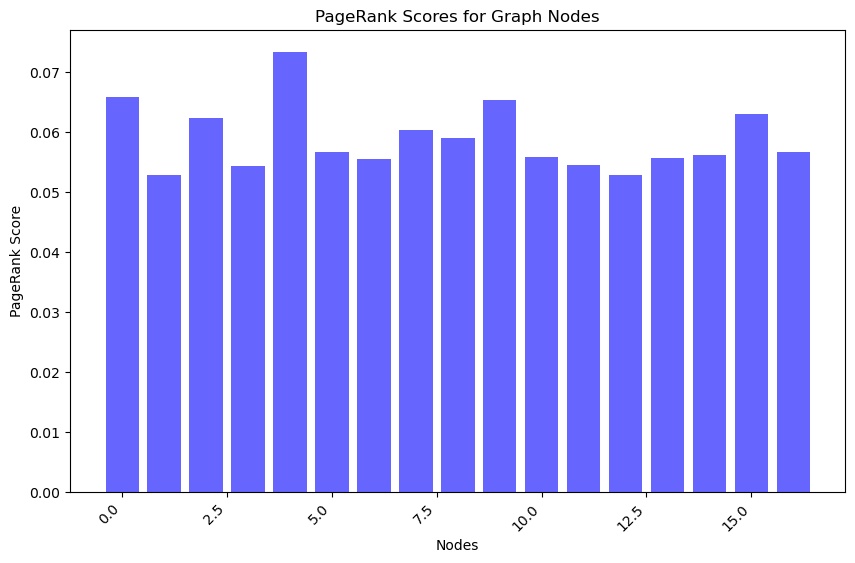

In [44]:
sorted_nodes = sorted(pagerank_scores, key=pagerank_scores.get, reverse=True)
sorted_scores = [pagerank_scores[node] for node in sorted_nodes]

    # Visualize the PageRank scores
plt.figure(figsize=(10, 6))
plt.bar(sorted_nodes, sorted_scores, color='blue', alpha=0.6)
plt.xlabel('Nodes')
plt.ylabel('PageRank Score')
plt.title('PageRank Scores for Graph Nodes')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [45]:
ranked_sentences = sorted(((pagerank_scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)
ranked_sentences

[(0.07331726364945652,
  'Nigel McCune Musicians\' Union said British musicians "disadvantaged" compared counterparts.'),
 (0.06579787736080814,
  "Musicians tackle red tape Musicians' groups tackle visa regulations blamed hindering British acts' chances succeeding across Atlantic."),
 (0.06537892617521154,
  'The Musicians\' Union stance endorsed Music Managers\' Forum (MMF), say British artists face "an uphill struggle" succeed US, thanks tough visa requirements, also seen impractical.'),
 (0.0629580409344292,
  'Embassy spokesman said: "We aware entertainers require visas time-specific visas everything process applications speedily."'),
 (0.06225180960754485,
  'Groups including Musicians\' Union calling end "raw deal" faced British performers.'),
 (0.060227354321002034,
  '"The world\'s biggest music market, means something done creaky bureaucracy," says McCune.'),
 (0.05904515286372326,
  '"The current situation preventing British acts maintaining momentum developing US," added.')

In [46]:
num_sentences = 5

# Extract the top-ranked sentences for the summary
summary_pr = " ".join([sentence for _, sentence in ranked_sentences[:num_sentences]])

In [47]:
summary_pr

'Nigel McCune Musicians\' Union said British musicians "disadvantaged" compared counterparts. Musicians tackle red tape Musicians\' groups tackle visa regulations blamed hindering British acts\' chances succeeding across Atlantic. The Musicians\' Union stance endorsed Music Managers\' Forum (MMF), say British artists face "an uphill struggle" succeed US, thanks tough visa requirements, also seen impractical. Embassy spokesman said: "We aware entertainers require visas time-specific visas everything process applications speedily." Groups including Musicians\' Union calling end "raw deal" faced British performers.'

In [48]:
# Pagerank function

def pagerank_summary(text, n):
    
    txt = text_cleaner(text)
    sentences = nltk.sent_tokenize(txt)

    # Tokenize words and remove stop words
    stop_words = set(stopwords.words("english"))
    word_tokens = [word_tokenize(sentence) for sentence in sentences]
    filtered_tokens = [[word.lower() for word in words if word.isalnum() and word.lower() not in stop_words] for words in word_tokens]
    sentences
    
    # Create a TF-IDF matrix
    corpus = [" ".join(words) for words in filtered_tokens]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    similarity_matrix = (tfidf_matrix * tfidf_matrix.T).toarray()
    
    graph = nx.from_numpy_array(similarity_matrix)
    
    
    pagerank_scores = nx.pagerank(graph)
    
    ranked_sentences = sorted(((pagerank_scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)

    num_sentences_in_summary = n

    # Extract the top-ranked sentences for the summary
    summary = " ".join([sentence for _, sentence in ranked_sentences[:num_sentences_in_summary]])

    return summary


### 6. Testing each model functions summarization and compare length with test data

Choosing one article from the dataset to be use as the test data. The text data will be applied into each model's functions and compare the number count. 

Based on the results below, the lowest summarization word counts is TF-IDF. However, this does not indicates that it is the best approach and quality of summarization as it also depends on the number of sentences set which is a bit difficult to conduct for K-Means Clusterer model.

In [49]:
test_text = df['Article'][2]
test_summ = df['Summary'][2]

In [50]:
pr_summ = pagerank_summary(test_text, 5)
print("Length of original text: ", len(test_text))
print("Length of summarize text: ", len(pr_summ), "\n", pr_summ)

Length of original text:  2127
Length of summarize text:  439 
 Babyshambles, formed acrimonious departure Libertines, played warm-up show The Garage, north London, Monday. Babyshambles played 5,000 fans London's Brixton Academy Tuesday. Rocker Doherty on-stage fight Rock singer Pete Doherty involved fight band's guitarist biggest gig date. The former Libertines singer traded blows guitarist Patrick Walden. Â£50,000 bail judge agreed extend 2200 GMT curfew deadline two hours could play Brixton gig.


In [51]:
tfidf_summ = generate_summary_tfidf(test_text, 5)
print("Length of original text: ", len(test_text))
print("Length of summarize text: ", len(tfidf_summ), "\n", tfidf_summ)

Length of original text:  2127
Length of summarize text:  347 
 Rocker Doherty on-stage fight Rock singer Pete Doherty involved fight band's guitarist biggest gig date.
Babyshambles played 5,000 fans London's Brixton Academy Tuesday.
The former Libertines singer traded blows guitarist Patrick Walden.
They separated bundled stage returning end set.
Monday Doherty faced blackmail robbery charges court, denies.


In [52]:
km_summ = generate_summary(test_text)
print("Length of original text: ", len(test_text))
print("Length of summarize text: ", len(km_summ), "\n", km_summ)

Number of rows of the example text dataframe:  18
Number cluster:  10
Length of original text:  2127
Length of summarize text:  920 
 Babyshambles played 5,000 fans London's Brixton Academy Tuesday. The former Libertines singer traded blows guitarist Patrick Walden. Monday Doherty faced blackmail robbery charges court, denies. Â£50,000 bail judge agreed extend 2200 GMT curfew deadline two hours could play Brixton gig. Babyshambles, formed acrimonious departure Libertines, played warm-up show The Garage, north London, Monday. Babyshambles took stage frenzied reception 2200 GMT, launching last single, Killamangiro, reached number eight December. Doherty appealed fans calm down, saying: "There's people getting hurt front, got move back." Bouncers stepped band left stage, returned five minutes finished 50-minute performance trouble. Monday, judge agreed allow perform condition requests changes bail terms "not regular occurrence". The singer arrested fellow musician Alan Wass February alleg

### 7.1 Model evaluation & result using TRAIN data: BLEU score
The evaluation of the model above using two methods, BLEU and Rogue. Based on the result for BLEU, K-Means Clusterer scores the highest, followed by PageRank and then TF-IDF.

In [53]:
hypothesis = kcluster_summary
reference = train_summary
BLEUscore_kcluster = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_kcluster}")

BLEUscore : 0.6554358604168459


In [54]:
hypothesis = final_summ
reference = train_summary
BLEUscore_tfidf = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_tfidf}")

BLEUscore : 0.34212527391975306


In [55]:
hypothesis = summary_pr
reference = train_summary
BLEUscore_pgr = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_pgr}")

BLEUscore : 0.4721980828059771


In [56]:
scores = pd.DataFrame({
    'Scores': ['K-Mean Cluster','TIFIDF', 
              'PageRank'],
    
    'Score_train': [BLEUscore_kcluster, BLEUscore_tfidf,  
              BLEUscore_pgr]})

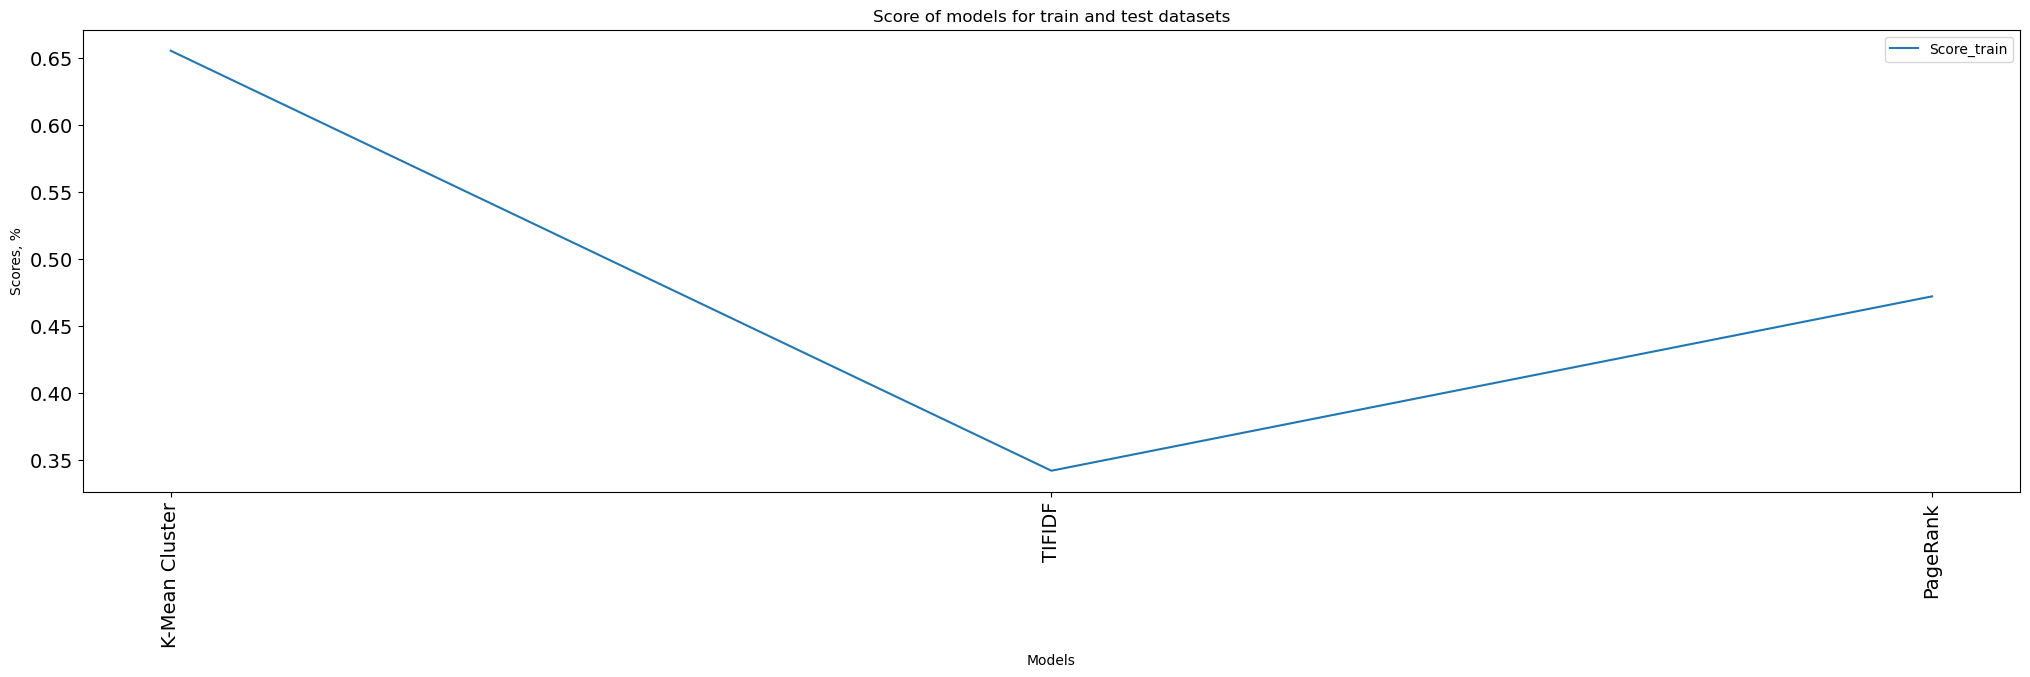

In [57]:
plt.figure(figsize=[25,6])
xx = scores['Scores']
plt.tick_params(labelsize=14)
plt.plot(xx, scores['Score_train'], label = 'Score_train')
plt.legend()
plt.title('Score of models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Scores, %')
plt.xticks(xx, rotation='vertical')
plt.show()

Based on the score as well the visualization of the graph, K-Mean Clusterer appears to score the highest. In order to obtain the final outcome of the result for a better accuracy, another evaluation method will be used. In the next section, the evaluation using ROGUE score will be executed.

### 7.2 Model evaluation & result using TEST data: BLEU score

In [58]:
hypothesis = km_summ
reference = test_summ
BLEUscore_km = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_km}")

BLEUscore : 0.5888437579425374


In [59]:
hypothesis = tfidf_summ
reference = test_summ
BLEUscore_tf = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_tf}")

BLEUscore : 0.18463191195307127


In [60]:
hypothesis = pr_summ
reference = test_summ
BLEUscore_pr = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_pr}")

BLEUscore : 0.3409050888161509


#### 7.1.1 Visualizing scores

In [61]:
scores = pd.DataFrame({
    'Scores': ['K-Mean Cluster','TIFIDF', 
              'PageRank'],
    
    'Score_train': [BLEUscore_km, BLEUscore_tf,  
              BLEUscore_pr]})


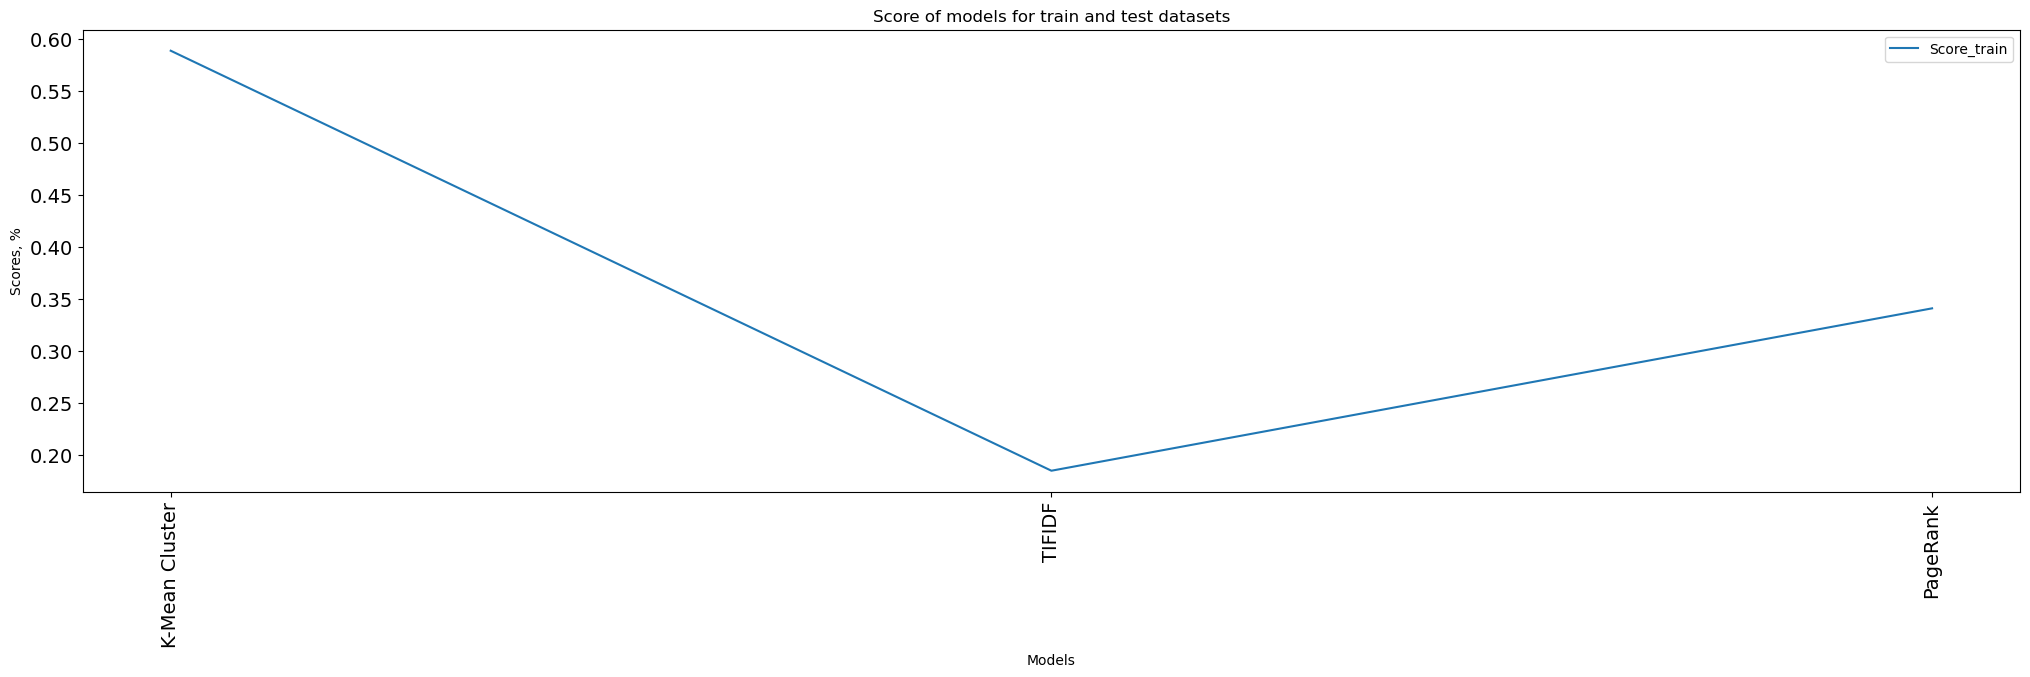

In [62]:
plt.figure(figsize=[25,6])
xx = scores['Scores']
plt.tick_params(labelsize=14)
plt.plot(xx, scores['Score_train'], label = 'Score_train')
plt.legend()
plt.title('Score of models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Scores, %')
plt.xticks(xx, rotation='vertical')
plt.show()

The result is similar to when using the training dataset.

### 7.3 Model evaluation & result with TRAIN data: ROGUE(Recall-Oriented Understudy for Gisting Evaluation) score
ROUGE score measures the similarity between the machine-generated summary and the reference summaries using overlapping n-grams, word sequences that appear in both the machine-generated summary and the reference summaries

In [63]:
rouge = evaluate.load('rouge')

In [64]:
candidates = [kcluster_summary]

references = [train_summary]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.47586206896551725, 'rouge2': 0.2569444444444444, 'rougeL': 0.2827586206896552, 'rougeLsum': 0.2827586206896552}


In [65]:
candidates = [final_summ]

references = [train_summary]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.36752136752136755, 'rouge2': 0.1724137931034483, 'rougeL': 0.21367521367521367, 'rougeLsum': 0.358974358974359}


In [66]:
candidates = [summary_pr]

references = [train_summary]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.5333333333333333, 'rouge2': 0.31092436974789917, 'rougeL': 0.3083333333333333, 'rougeLsum': 0.3083333333333333}


#### 7.2.1 Visualizing score

In [67]:
from rouge import Rouge
def calculate_rouge_scores(hypotheses, references):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

In [68]:
def visualize_rouge_comparison(techniques, hypotheses, references):
    colors = ['blue', 'pink', 'red']

    plt.figure(figsize=(10, 6))

    for i, technique in enumerate(techniques):
        scores = calculate_rouge_scores(hypotheses[technique], references)
        categories = list(scores.keys())
        values = [scores[category]['f'] * 100 for category in categories]

        plt.bar([cat + f" ({technique})" for cat in categories], values, color=colors[i], alpha=0.6)

    plt.ylabel('ROUGE F1 Score (%)')
    plt.xticks(rotation=75)
    plt.title('Comparison of ROUGE Scores for Summarization models')
    plt.legend(techniques)
    plt.show()

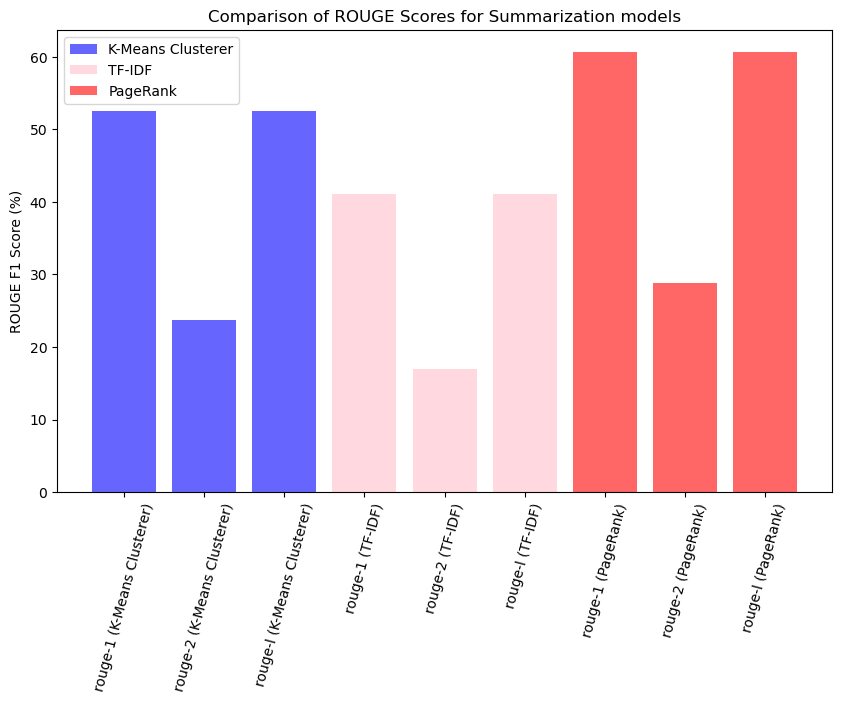

In [69]:
kmeans_hypotheses = [kcluster_summary]
tfidf_hypotheses = [final_summ]
pagerank_hypotheses = [summary_pr]
references = [train_summary]

# Visualize ROUGE scores for the three techniques
visualize_rouge_comparison(['K-Means Clusterer', 'TF-IDF', 'PageRank'],
                           {'K-Means Clusterer': kmeans_hypotheses, 'TF-IDF': tfidf_hypotheses, 'PageRank': pagerank_hypotheses},
                           references)

With BLEU score, K-Means Clusterer scores the highest followed steeply by PageRank and finally TF-IDF. However, using ROGUE score, K-Means Clusterer scores the lowest at 0.4148 (rogue-1) as well as for all types of rogue evaluation while PageRank remains its high score at 0.7686 (rogue-1). 

This concludes that PageRank approach is the suitable model to use and yields a better summary.

### 7.4 Model evaluation & result with TEST data: ROGUE(Recall-Oriented Understudy for Gisting Evaluation) score

In [70]:
candidates = [km_summ]

references = [test_summ]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.4452296819787986, 'rouge2': 0.23487544483985767, 'rougeL': 0.22614840989399296, 'rougeLsum': 0.22614840989399296}


In [71]:
candidates = [tfidf_summ]

references = [test_summ]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.4, 'rouge2': 0.22660098522167485, 'rougeL': 0.24390243902439027, 'rougeLsum': 0.39024390243902435}


In [72]:
candidates = [pr_summ]

references = [test_summ]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.5727272727272728, 'rouge2': 0.3211009174311927, 'rougeL': 0.4636363636363636, 'rougeLsum': 0.4636363636363636}


#### 7.4.1 Visualizing score

In [73]:
def calculate_rouge_scores(hypotheses, references):
    rouge = Rouge()
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

In [74]:
def visualize_rouge_comparison(techniques, hypotheses, references):
    colors = ['blue', 'pink', 'red']

    plt.figure(figsize=(10, 6))

    for i, technique in enumerate(techniques):
        scores = calculate_rouge_scores(hypotheses[technique], references)
        categories = list(scores.keys())
        values = [scores[category]['f'] * 100 for category in categories]

        plt.bar([cat + f" ({technique})" for cat in categories], values, color=colors[i], alpha=0.6)

    plt.ylabel('ROUGE F1 Score (%)')
    plt.xticks(rotation=75)
    plt.title('Comparison of ROUGE Scores for Summarization models')
    plt.legend(techniques)
    plt.show()

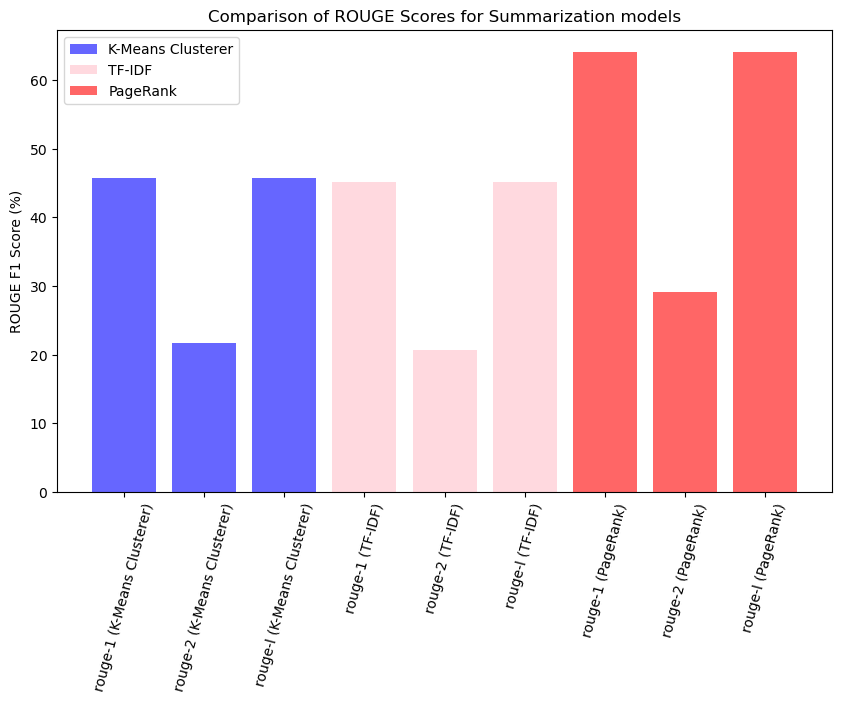

In [75]:
kmeans_hypotheses = [km_summ]
tfidf_hypotheses = [tfidf_summ]
pagerank_hypotheses = [pr_summ]
references = [test_summ]

# Visualize ROUGE scores for the three techniques
visualize_rouge_comparison(['K-Means Clusterer', 'TF-IDF', 'PageRank'],
                           {'K-Means Clusterer': kmeans_hypotheses, 'TF-IDF': tfidf_hypotheses, 'PageRank': pagerank_hypotheses},
                           references)

Similar result when using the training data.

### 7.5 Overall evaluation


Based on the overall scores of each models, PageRank approach appears to score particular well on both evaluation compare to the other two models. While K-Mean Clusterer scores the highest for BLEU, it is the lowest for ROGUE especially as seen from the rogue-2 score while PageRank scores the highest for all 3 types of ROGUE score. Hence, the PageRank approach will be use for the deployment of the model for simple text summarization application. 

### 8. Hyperparameter tuning with TEST data

Hyperparameter tuning is a process of which allows data scientists to tweak model performance for optimal results. In this case, with PageRank scores the best out of 3 models, there 3 hyperparameters identified in order to be used for tuning: n-gram range, parameter for tfidf vectorizer and the use of stopwords. These hyperparameters will be tweaked when the fuction is being called and the result will be evaluated using both BLEU and ROUGE to be compared with PageRank without tuning its hyperparameter.  

In [82]:
#function for hyperparameter tuning for PageRank

def hyper_pagerank(text, n, vectorizer_params=None, use_stop_words=True):
    txt = text_cleaner(text)
    sentences = nltk.sent_tokenize(txt)
    stop_words = set(stopwords.words("english"))

    # Tokenize words and remove stop words
    word_tokens = [word_tokenize(sentence) for sentence in sentences]
    filtered_tokens = [[word.lower() for word in words if word.isalnum() and word.lower() not in stop_words] for words in word_tokens]

    # Create a TF-IDF matrix with customizable parameters
    vectorizer_params = vectorizer_params or {}
    vectorizer = TfidfVectorizer(**vectorizer_params)
    tfidf_matrix = vectorizer.fit_transform([" ".join(words) for words in filtered_tokens])

    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Build the graph
    graph = nx.from_numpy_array(similarity_matrix)

    pagerank_scores = nx.pagerank(graph)

    ranked_sentences = sorted(((pagerank_scores[i], sentence) for i, sentence in enumerate(sentences)), reverse=True)

    # Extract the top-ranked sentences for the summary
    num_sentences_in_summary = n
    summary = " ".join([sentence for _, sentence in ranked_sentences[:num_sentences_in_summary]])

    return summary

# Normal settings: ngram = (1,2), use_idf = True, smooth_idf = True
vectorizer_params = {'ngram_range': (1, 1), 'use_idf': False, 'smooth_idf': True}
h_summary = hyper_pagerank(test_text, n=5, vectorizer_params=vectorizer_params, use_stop_words=True)
print(h_summary)
#if you change use_idf to False, BLEUscore higher or BOTH idf false

Rocker Doherty on-stage fight Rock singer Pete Doherty involved fight band's guitarist biggest gig date. Babyshambles, formed acrimonious departure Libertines, played warm-up show The Garage, north London, Monday. Babyshambles played 5,000 fans London's Brixton Academy Tuesday. Monday Doherty faced blackmail robbery charges court, denies. Tuesday, Doherty three bandmates introduced crowd Mick Jones, former Clash guitarist produced Libertines' second album.


In [83]:
hypothesis = h_summary
reference = test_summ
BLEUscore_h = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(f"BLEUscore : {BLEUscore_h}")

BLEUscore : 0.37368024340873973


In [84]:
candidates = [h_summary]

references = [train_summary]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.035398230088495575, 'rouge2': 0.0, 'rougeL': 0.02654867256637168, 'rougeLsum': 0.02654867256637168}


In [85]:
scores = pd.DataFrame({
    'Scores': ['PageRank', 'PageRank Hyperparameter'],
    
    'Score_train': [BLEUscore_pr, BLEUscore_h]})

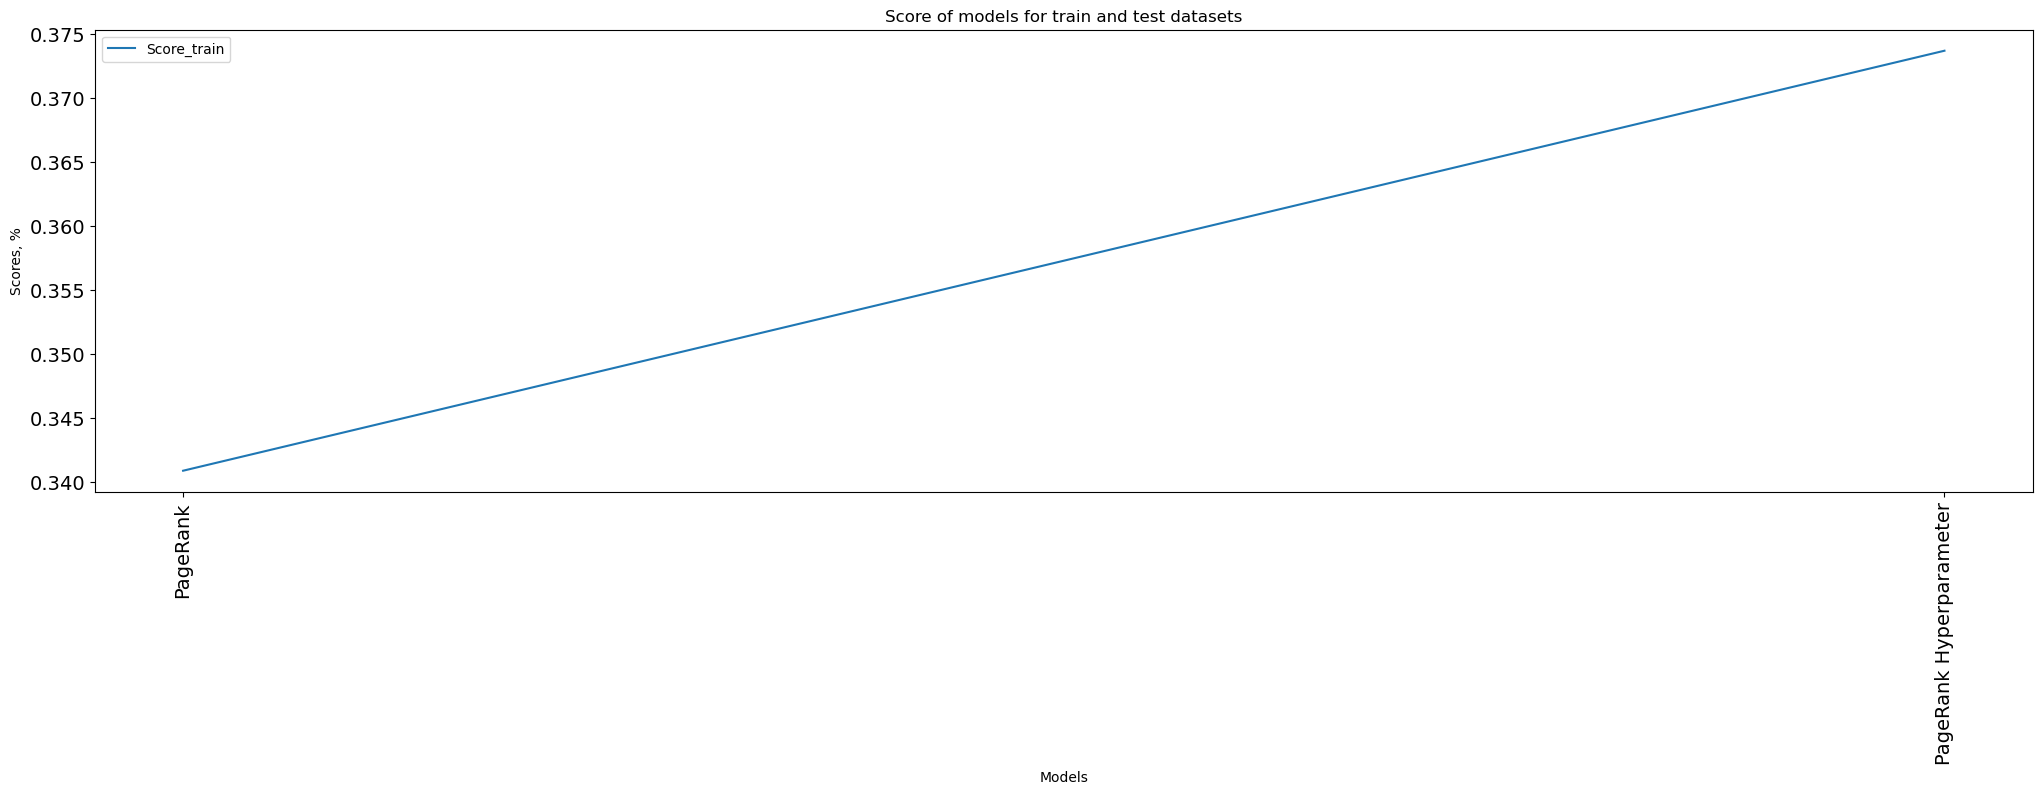

In [86]:
plt.figure(figsize=[25,6])
xx = scores['Scores']
plt.tick_params(labelsize=14)
plt.plot(xx, scores['Score_train'], label = 'Score_train')
plt.legend()
plt.title('Score of models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Scores, %')
plt.xticks(xx, rotation='vertical')
plt.show()

#### 8.1 Result of BLEU

The result shows that by tweaking the hyperparameter into a unigram, removing use_idf, keeping smooth_idf and keeping stopwords. There appear to be an improvement of the model with hyperparameter tuning. BLEU score without hyperparameter tuning is 34% while with hyperparameter tuning is 37% which is a 3% increase.

#### 8.2 ROGUE score for PageRank without hyperparameter tuning and with hyperparameter tuning.

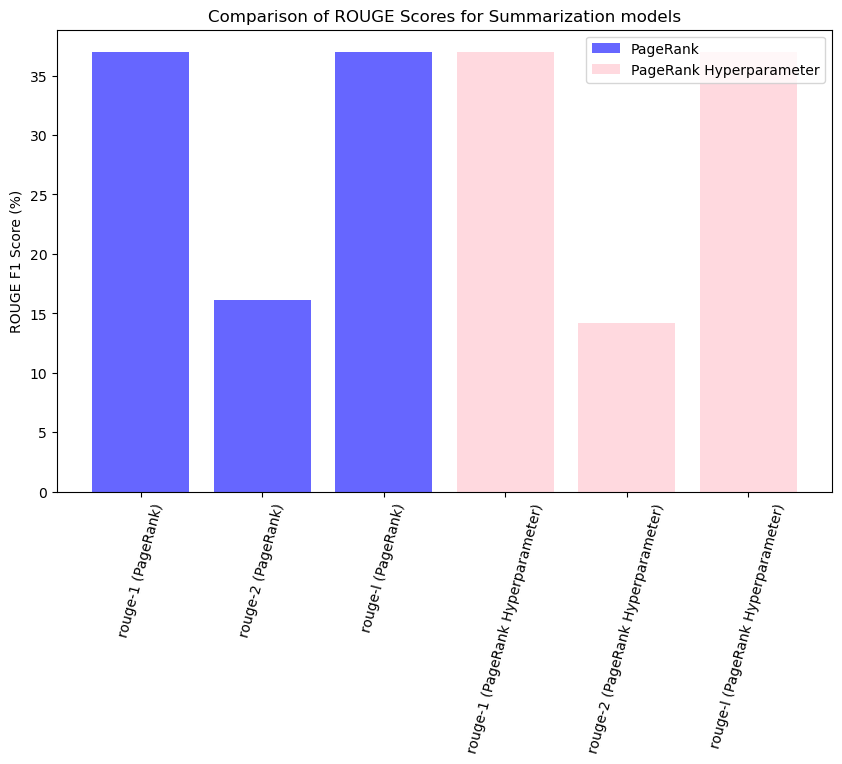

In [87]:
pagerank_hypotheses = [pr_summ]
pagerank_hyperparam_hypotheses = [h_summary]
references = [test_text]
visualize_rouge_comparison(['PageRank', 'PageRank Hyperparameter'],
                           {'PageRank': pagerank_hypotheses, 'PageRank Hyperparameter': pagerank_hyperparam_hypotheses},
                           references)


However, upon further evaluation with ROGUE score, it appears to have no difference. Despite that, with an increase in BLEU score and the equal score for ROGUE might indicates that there might a slight improvement towards the model's performance through a correct hyperparameter tuning.

### 9. Result and discussion
Q: What were the main findings or results of your NLP project? And did you include visualizations or graphs to support your findings?

Based on the result and the graphs generated during evaluation, the best summary generated by using PageRank model compare the other model especially during the evaluation using BLEU score in which K-Means leads the score with PageRank second with a small differences. However, upon further evaluation using ROGUE(Recall-Oriented Understudy for Gisting Evaluation) for deeper clarification, PageRank leads the score for all types of score of ROGUE which makes it the best model for text summarization.

Furthermore, hyperparameter tuning was conducted for PageRank model in order to optimize its performance. By tuning the parameters of n-gram range, the TF-IDF parameters, and whether to remove stopwords or not. By performing the hyperparameter tuning, the result shows for BLEU that there is an improvement to the model score of 3% increase while ROGUE scores shows that there's no improvement between conducting hyperparameter tuning and without, result remain the same with slight miniscule decrease from rogue-2 score when using hyperparameter tuning which could be factored by various reason. Overall, based on BLEU score there appears to be an improvement if conducting hyperparparameter tuning.


Finally, to answer the research topic of this project whether the generated summary is better than the original summary, the scores provided implies that there has been a slight improvement of 57% accuracy via ROGUE-1 and ROGUE-l scores. Hence, it concludes that the null hypotheses will be rejected.

Q: How do your results compare to existing research in the field?

The existing research conducted by user (https://www.kaggle.com/code/vshantam/text-summarization-extractive-bleu) shown that they have a lower BLEU score. However, the method that they are using are different which might affect the performance but in overall perspective, an there are an improvement through the methods use in this project hence, it would conclude that the result yield from this project have shown that text summarization have bigger room for improvement by using multiple methods.

### 10. Challenges faced
 
Among the challenges faced during this project was how I was unable to install a library such as Tensorflow pre-trained model without causing kernel crashed. However, this has been overcome by properly installing it with the correct steps and requirement needed until it eventually allows me to use the model. It is as learning lesson for me that I should ensure proper installation before running the library in order to avoid repeating the same issue in the future.

Aside from that, there are challenges such as figuring the correct model to use for text summarization and how to split dataset. Since text summarization does not require elaborate train-test split and are mostly use a simple paragraph as a data as it rarely used a supervised leaning approach for text summarization. Hence, there are no train-test split since most of the models and approaches use for this research are using an unsupervised learning approach and non-traditional ML model such as PageRank. Hence, it is difficult to really figure out how to calculate the accuracy score of the mode. To fix this, for K-Means Clusterer, I'm using Silhouette Score to measure its accuracy by using the assigned cluster. The result shows that it is a relatively a good performance. Next, for the measurement of performance for all three models is using the BLEU score and the ROGUE score which measures the quality between the summary generated from the original dataset with the summary generated by the model used for this project.

Finally, difficulties in developing the hyperparameter tuning for the best model which in this case is the PageRank. There are lack of hyperparameters to tune for PageRank as it is a graph based model. Despite that, I managed to solve by tweaking the parameters for the TF-IDF, the n-gram range and the use of stopwords in order to find any sort of improvisation by tuning the hyperparameter.

### 11. Future works

To use more model in order to compare each result better. More precisely, using a supervised learning approach and whether it is suitable for text summarization since more often, text summarization commonly use unsupervised learning approach with no labelled data. 

Furthermore, to use the abtstractive method of text summarization and compare it with extractive to see which produces better outputs of summarization.